https://pytorch.org/vision/master/auto_examples/plot_scripted_tensor_transforms.html


In [ ]:
from pathlib import Path
import torch
import torchvision.transforms as T
import torch.nn as nn
from torchvision.io import read_image

In [ ]:
# Carga las imágenes dogs o cars
dog1 = read_image(str(Path('assets') / 'dog1.jpg'))
dog2 = read_image(str(Path('assets') / 'dog2.jpg'))

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
transforms = torch.nn.Sequential(
    T.CenterCrop(240),
    T.RandomHorizontalFlip(p=0.5),
)

# Transforming images on GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dog1 = dog1.to(device)
dog2 = dog2.to(device)

transformed_dog1 = transforms(dog1)
transformed_dog2 = transforms(dog2)

In [ ]:
# Funcion auxiliar para ver las imágenes
import matplotlib.pyplot as plt
import numpy as np

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

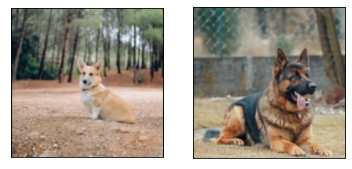

In [ ]:
show([dog1, dog2])

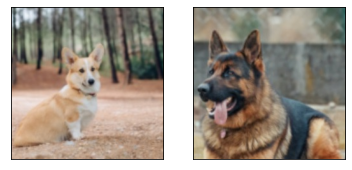

In [ ]:
show([transformed_dog1, transformed_dog2])

## Scriptable transforms for easier deployment via torchscript

In [ ]:
from torchvision.models import densenet161, DenseNet161_Weights


class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        weights = DenseNet161_Weights.DEFAULT
        self.densenet161 = densenet161(weights=weights, progress=False).eval()
        self.transforms = weights.transforms()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.densenet161(x)
            return y_pred.argmax(dim=1)

In [ ]:
predictor = Predictor().to(device)
scripted_predictor = torch.jit.script(predictor).to(device)

batch = torch.stack([transformed_dog1, transformed_dog2]).to(device)

res = predictor(batch)
res_scripted = scripted_predictor(batch)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


In [ ]:
import json

with open(Path('assets') / 'imagenet_class_index.json') as labels_file:
    labels = json.load(labels_file)

for i, (pred, pred_scripted) in enumerate(zip(res, res_scripted)):
    assert pred == pred_scripted
    print(f"Prediction for Dog {i + 1}: {labels[str(pred.item())]}")

Prediction for Dog 1: ['n02113186', 'Cardigan']
Prediction for Dog 2: ['n02106662', 'German_shepherd']
